# Numerical Differentiation

In this notebook, we explore numerical differentiation methods to approximate derivatives of functions. We cover two main approaches:

## Topics covered:
- **Finite Differences:** Uses a central difference formula for a good balance of simplicity and accuracy.
- **Spectral collocation:** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Second-Order Finite Difference:

In this example, we approximate the first derivative $f'(x)$ of a function using the second-order central finite difference formula:

$$
f'(x_i) \approx \frac{f(x_{i+1}) - f(x_{i-1})}{2h},
$$

where $h$ is the spacing between adjacent grid points.

#### What This Code Does

- **Domain Setup:**  
  The domain $[0, 2\pi]$ is discretized into N evenly spaced points, and the grid spacing $h$ is computed.

- **Numerical Derivative Calculation:**  
  The numerical derivative is computed using the central finite difference formula, which approximates the derivative at a point using the function values at neighboring points.

- **Comparison with the Exact Derivative:**  
  Both the exact derivative (from the analytical solution) and the numerical approximation are plotted together. This visual comparison helps assess the accuracy of the second-order finite difference method.

The method achieves a truncation error of $O(h^2)$, meaning that as $h$ becomes smaller, the error in the approximation decreases quadratically. More on this below.

Let's make some function-definitions first:


In [2]:
def f(x):
  return np.sin(x)

def f_prime_exact(x):
  return np.cos(x)

def f_prime_second(x, h):
    return (f(x + h) - f(x - h)) / (2 * h)


The coefficients above for each stencil can be easily computed from https://web.media.mit.edu/~crtaylor/calculator.html

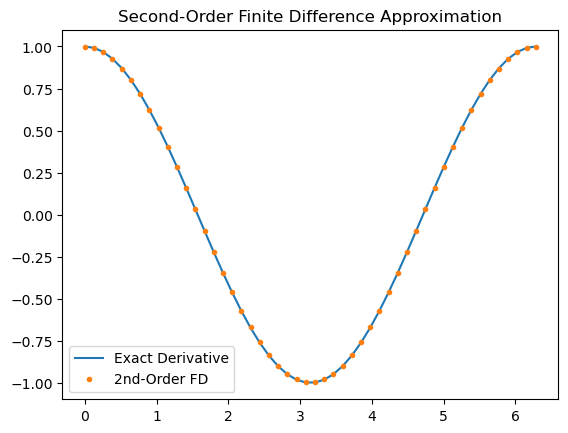

In [3]:
# Define the domain and grid spacing
x = np.linspace(0, 2*np.pi, 50)
h = x[1] - x[0]

f_prime_numerical = f_prime_second(x,h)

plt.plot(x, f_prime_exact(x), label="Exact Derivative")
plt.plot(x, f_prime_numerical, '.', label="2nd-Order FD")
plt.legend()
plt.title("Second-Order Finite Difference Approximation")
plt.show()

#### Fourth-Order Finite Difference:

Provides higher accuracy by using a wider stencil.


In [4]:
def f_prime_fourth(x, h):
    return (-f(x+2*h) + 8*f(x+h) - 8*f(x-h) + f(x-2*h)) / (12*h)

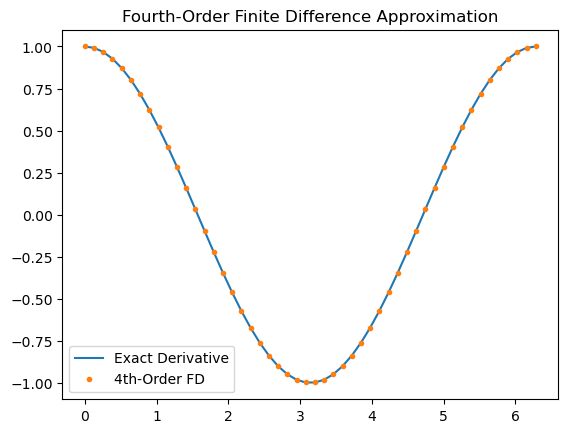

In [5]:
f_prime_numerical_4th = f_prime_fourth(x, h)

plt.plot(x, f_prime_exact(x), label="Exact Derivative")
plt.plot(x, f_prime_numerical_4th, '.', label="4th-Order FD")
plt.legend()
plt.title("Fourth-Order Finite Difference Approximation")
plt.show()


The following snippet demonstrates the concept of **truncation error**, defined above. For a given number of nodes, we compute the norm of the absolute error between the actual derivative and the one numerically computed. We should see that this error decays algebraically, i.e., $\mathrm{error} \propto ~ h^{n}$, where $n$ is said to be the *order of discretization*.

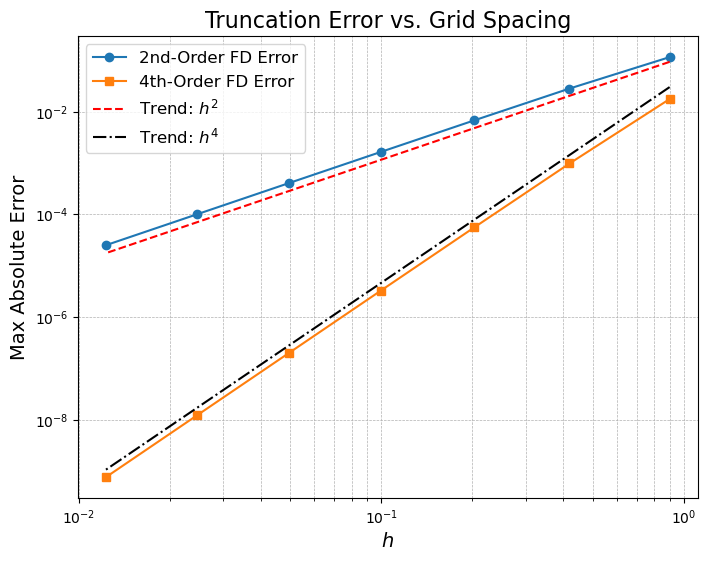

In [6]:
# Define the domain [a, b]
a, b = 0, 2*np.pi

# Create a vector of grid sizes: [8, 16, 32, ..., 1024]
N_values = 2**np.arange(3,10)  # 2^3 = 8 up to 2^10 = 1024

errors_second = []
errors_fourth = []
h_values = []

for N in N_values:
    x = np.linspace(a, b, N)
    h = x[1] - x[0]
    h_values.append(h)
    
    # For the 2nd-order scheme, use interior points: indices 1 to N-2
    x_interior_2 = x[1:-1]
    exact_2 = f_prime_exact(x_interior_2)
    numerical_2 = f_prime_second(x, h)[1:-1]
    error_2 = np.max(np.abs(exact_2 - numerical_2))
    errors_second.append(error_2)
    
    # For the 4th-order scheme, use interior points: indices 2 to N-3
    x_interior_4 = x[2:-2]
    exact_4 = f_prime_exact(x_interior_4)
    numerical_4 = f_prime_fourth(x, h)[2:-2]
    error_4 = np.max(np.abs(exact_4 - numerical_4))
    errors_fourth.append(error_4)

h_values = np.array(h_values)
errors_second = np.array(errors_second)
errors_fourth = np.array(errors_fourth)

# Create reference trend lines. We choose the scaling so that the reference line
# passes through the last computed error point.
scale2 = errors_second[-1] / h_values[-1]**2
scale4 = errors_fourth[-1] / h_values[-1]**4

ref2 = 0.70*scale2 * h_values**2 
ref4 = 1.40*scale4 * h_values**4

# Plotting the errors and reference trends on a log-log plot
plt.figure(figsize=(8, 6))
plt.loglog(h_values, errors_second, 'o-', label='2nd-Order FD Error')
plt.loglog(h_values, errors_fourth, 's-', label='4th-Order FD Error')
plt.loglog(h_values, ref2, 'r--', label=r'Trend: $h^2$')
plt.loglog(h_values, ref4, 'k-.', label=r'Trend: $h^4$')

plt.xlabel(r'$h$', fontsize=14)
plt.ylabel('Max Absolute Error', fontsize=14)
plt.title('Truncation Error vs. Grid Spacing', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()


I hope you can see now why each discretization is called an n-th order FD discretization.

## Spectral Collocation

Spectral collocation is a high-accuracy method for numerical differentiation based on approximating functions by global interpolants (typically polynomials or trigonometric series).

By enforcing that the derivative matches at carefully chosen **collocation points** (Chebyshev nodes), we construct a **differentiation matrix** that acts directly on function values.

Trefethen's method uses Chebyshev nodes defined by  
$$
x_j = \cos\left(\frac{\pi j}{N}\right), \quad j = 0, 1, \dots, N,
$$  
and builds a matrix \(D\) such that the derivative of a function \(f\) is approximated by  
$$
f'(x_j) \approx (Df)_j.
$$

This yields **spectral accuracy** for smooth functions, with errors that decay faster than any power of \(1/N\). For further details, see:

> L. N. Trefethen, *Spectral Methods in MATLAB*, SIAM, 2000.

The matrix \(D\) and the associated Chebyshev nodes are computed as follows (you can just copy/paste it for your applications).

### Higher-Order Derivatives

One of the elegant features of spectral collocation is that it makes computing higher-order derivatives almost as straightforward as computing the first derivative. To approximate the \(n\)th derivative of a function \(f\) at the collocation points, you can simply apply the differentiation matrix \(D\) repeatedly. In particular, for the fourth derivative, the approximation is given by:

$$
u^{(4)}(x_j) \approx (D^4 f)_j,
$$

where \(D^4\) denotes the fourth power of the differentiation matrix, obtained by multiplying \(D\) by itself four times. This direct matrix power approach highlights how the method leverages the same precomputed structure to efficiently handle derivatives of any order.

Keep in mind that while spectral collocation provides spectral accuracy, when computing high-order derivatives, one should be mindful of potential numerical stability issues such as round-off errors. For many smooth problems, however, using \(D^4\) to approximate the fourth derivative is both practical and highly accurate.


In [7]:
import numpy as np

def cheb(N):
    """Compute the Chebyshev differentiation matrix and Chebyshev nodes."""
    if N == 0:
        return np.array([[0]]), np.array([1.0])

    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.ones(N + 1)
    c[0] = 2
    c[-1] = 2
    c = c * ((-1) ** np.arange(N + 1))

    X = np.tile(x, (N + 1, 1)).T
    dX = X - X.T
    D = (c[:, None] / c[None, :]) / (dX + np.eye(N + 1))  # off-diagonal terms
    D = D - np.diag(np.sum(D, axis=1))                    # diagonal terms
    return D, x


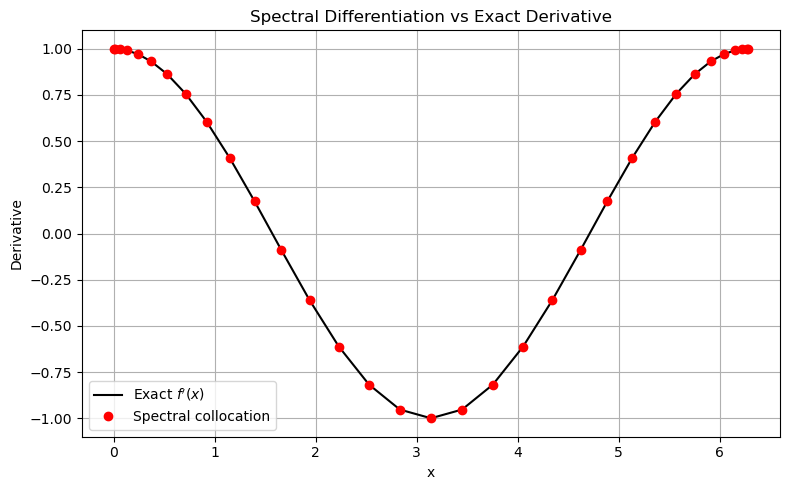

In [8]:
# Choose number of collocation points
N = 32
D, x_cheb = cheb(N)

# Map Chebyshev nodes from [-1, 1] to [0, 2π]
a, b = 0, 2*np.pi
x_mapped = 0.5 * (a + b) + 0.5 * (b - a) * x_cheb
D_mapped = (2 / (b - a)) * D  # chain rule scaling

# Evaluate function and compute spectral derivative
f_vals = f(x_mapped)
f_prime_spec = D_mapped @ f_vals # This is shorthand for matrix multiplication, equivalent to np.dot(D,f)
f_prime_true = f_prime_exact(x_mapped)

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(x_mapped, f_prime_true, 'k-', label='Exact $f\'(x)$')
plt.plot(x_mapped, f_prime_spec, 'ro', label='Spectral collocation')
plt.title("Spectral Differentiation vs Exact Derivative")
plt.xlabel("x")
plt.ylabel("Derivative")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Check the ordering of Chebyshev nodes:

In [9]:
print(x_cheb,"\n")
print(x_mapped)

[ 1.00000000e+00  9.95184727e-01  9.80785280e-01  9.56940336e-01
  9.23879533e-01  8.81921264e-01  8.31469612e-01  7.73010453e-01
  7.07106781e-01  6.34393284e-01  5.55570233e-01  4.71396737e-01
  3.82683432e-01  2.90284677e-01  1.95090322e-01  9.80171403e-02
  6.12323400e-17 -9.80171403e-02 -1.95090322e-01 -2.90284677e-01
 -3.82683432e-01 -4.71396737e-01 -5.55570233e-01 -6.34393284e-01
 -7.07106781e-01 -7.73010453e-01 -8.31469612e-01 -8.81921264e-01
 -9.23879533e-01 -9.56940336e-01 -9.80785280e-01 -9.95184727e-01
 -1.00000000e+00] 

[6.28318531 6.26805768 6.22282049 6.14790938 6.04404581 5.91223002
 5.75373148 5.57007662 5.36303412 5.13459793 4.88696802 4.62252918
 4.34382811 4.05354886 3.75448698 3.44952258 3.14159265 2.83366273
 2.52869833 2.22963644 1.93935719 1.66065613 1.39621729 1.14858737
 0.92015118 0.71310869 0.52945383 0.37095529 0.2391395  0.13527592
 0.06036482 0.01512763 0.        ]


Now, let's visualize spectral accuracy in action. With Chebyshev collocation, the error should decay spectrally (i.e., faster than any polynomial), especially for smooth functions like $\sin{x}$.

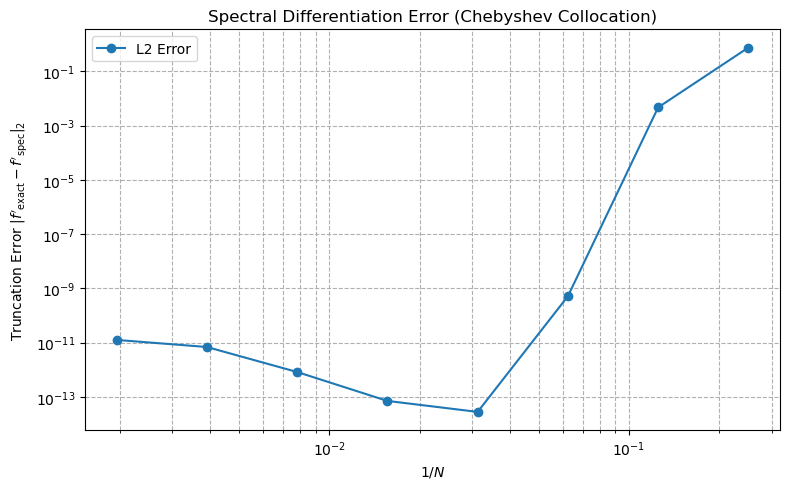

In [10]:
# Error vs 1/N
a, b = 0, 2 * np.pi
Ns = [2**k for k in range(2, 10)]  # k = 2, 3, 4, 5, ...
errors = []
hvals = [1 / N for N in Ns]

for N in Ns:
    D, x_cheb = cheb(N)
    x_mapped = 0.5 * (a + b) + 0.5 * (b - a) * x_cheb
    D_mapped = (2 / (b - a)) * D

    f_vals = f(x_mapped)
    f_prime_spec = np.dot(D_mapped, f_vals)
    f_prime_true = f_prime_exact(x_mapped)

    # L2 error
    error = np.linalg.norm(f_prime_spec - f_prime_true, ord=2) 
    errors.append(error)

# Plot
plt.figure(figsize=(8, 5))
plt.loglog(hvals, errors, 'o-', label="L2 Error")
plt.xlabel(r"$1/N$")
plt.ylabel(r"Truncation Error $\|f'_{\mathrm{exact}} - f'_{\mathrm{spec}}\|_2$")
plt.title("Spectral Differentiation Error (Chebyshev Collocation)")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

Collocation methods do not give very good results if the functions do not behave smoothly, i.e., develop steep gradients...

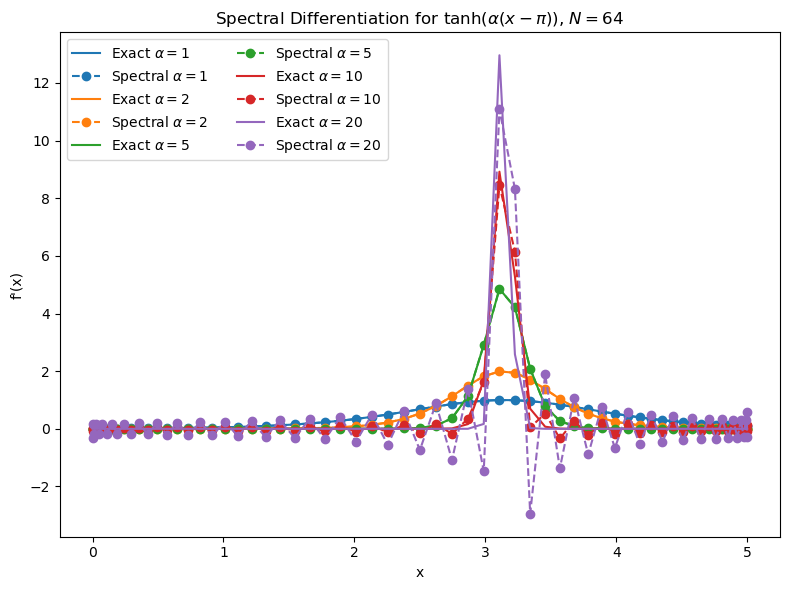

In [11]:
# Steep tanh function and exact derivative
def f(x, alpha):
    return np.tanh(alpha * (x - np.pi))

def f_prime_exact(x, alpha):
    return alpha * (1.0 / np.cosh(alpha * (x - np.pi))**2)

# Interval and Chebyshev setup
N = 64
a, b = 0, 5
D, x_cheb = cheb(N)
x_mapped = 0.5 * (a + b) + 0.5 * (b - a) * x_cheb
D_mapped = (2.0 / (b - a)) * D

# Different alpha values to test
alpha_values = [1, 2, 5, 10, 20]

plt.figure(figsize=(8, 6))

for alpha in alpha_values:
    # Numerical derivative with Chebyshev collocation
    f_vals = f(x_mapped, alpha)
    f_prime_spec = np.dot(D_mapped, f_vals)

    # Exact derivative
    f_prime_true = f_prime_exact(x_mapped, alpha)

    # Plot the exact derivative, get its color
    line_handle = plt.plot(x_mapped, f_prime_true, label=rf'Exact $\alpha={alpha}$')
    color_used = line_handle[0].get_color()  # same color for spectral

    # Plot the spectral derivative in the same color, using marker/linestyle
    plt.plot(x_mapped, f_prime_spec, 'o--', color=color_used, 
             label=rf'Spectral $\alpha={alpha}$')

plt.title(r"Spectral Differentiation for $\tanh(\alpha(x-\pi))$, $N=64$")
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.legend(ncol=2)  # Two columns to keep legend neat
plt.tight_layout()
plt.show()

⚠️ **Gibbs Phenomenon in Spectral Collocation**:

When $ \alpha $ is large, $ \tanh\bigl(\alpha(x - \pi)\bigr) $ transitions sharply around $ x = \pi $. In a polynomial collocation setting, the global interpolant attempts to match the steep transition exactly at each Chebyshev node, often leading to overshoots (oscillations) between the nodes. This effect, known as the **Gibbs phenomenon**, is not unique to Fourier series; it also appears in polynomial-based spectral methods whenever a function has rapid variations or discontinuities.  
While the solution remains highly accurate overall, these local oscillations can persist near steep gradients, highlighting a practical limitation of spectral collocation for non-smooth functions.


### An example: derivatives of a Gaussian Pulse

Let's compute the first, second, third, and fourth derivatives of a smooth Gaussian pulse using spectral collocation. Let the Gaussian pulse be defined as

$$
f(x) = e^{-100x^2}, \quad x \in [-1,1],
$$

and its derivatives are given by:

- **First derivative:** $f'(x) = -200x\, e^{-100x^2},$
- **Second derivative:**  $f''(x) = (40000x^2 - 200)e^{-100x^2},$
- **Third derivative:**  $f'''(x) = -200x\,(40000x^2 - 600)e^{-100x^2},$
- **Fourth derivative:** $f^{(4)}(x) = \left(1.6\times10^9\,x^4 - 4.8\times10^7\,x^2 + 1.2\times10^5\right)e^{-100x^2}.$

The following code shows how to compute these derivatives numerically using spectral collocation and then plot the numerical and exact derivatives for comparison. Play around with the number of grid points `N` to see the minimum amount of resolution needed to capture the gradients near the origin, $x \simeq 0$.

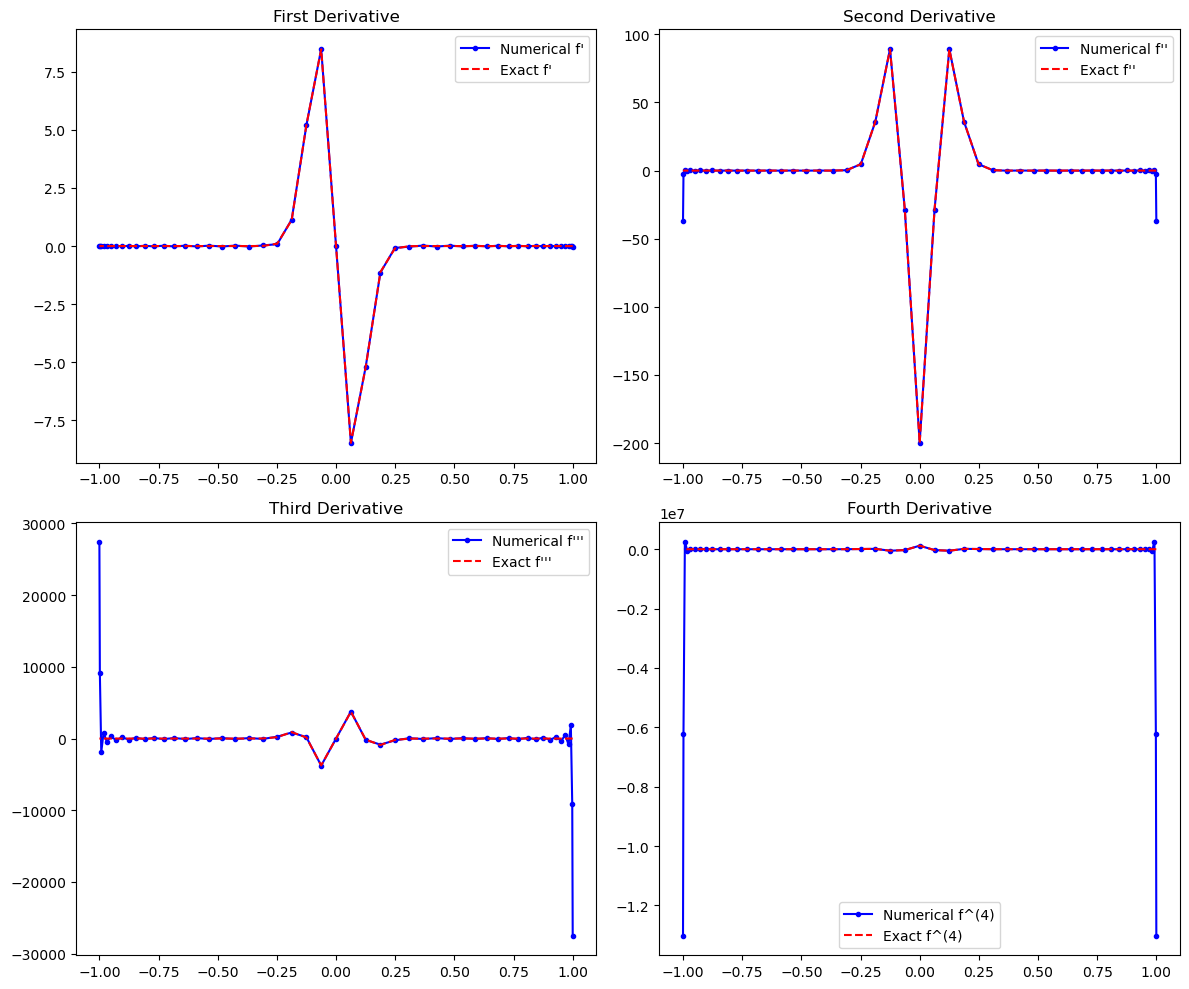

In [21]:
# Set the number of Chebyshev nodes
N = 50
D, x = cheb(N)

# Define the smooth Gaussian pulse
f = np.exp(-100 * x**2)

# Compute the differentiation matrices for higher derivatives
D1 = D
D2 = np.linalg.matrix_power(D, 2)
D3 = np.linalg.matrix_power(D, 3)
D4 = np.linalg.matrix_power(D, 4)

# Compute the numerical derivatives
f1_num = D1 @ f
f2_num = D2 @ f
f3_num = D3 @ f
f4_num = D4 @ f

# Analytical derivatives of f(x) = exp(-100*x^2)
f1_exact = -200 * x * np.exp(-100*x**2)
f2_exact = (40000*x**2 - 200) * np.exp(-100*x**2)
f3_exact = -200 * x * (40000*x**2 - 600) * np.exp(-100*x**2)
f4_exact = (1.6e9*x**4 - 48000000*x**2 + 120000) * np.exp(-100*x**2)

# Plotting the results
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(x, f1_num, 'b.-', label='Numerical f\'')
plt.plot(x, f1_exact, 'r--', label='Exact f\'')
plt.title('First Derivative')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x, f2_num, 'b.-', label='Numerical f\'\'')
plt.plot(x, f2_exact, 'r--', label='Exact f\'\'')
plt.title('Second Derivative')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x, f3_num, 'b.-', label='Numerical f\'\'\'')
plt.plot(x, f3_exact, 'r--', label='Exact f\'\'\'')
plt.title('Third Derivative')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(x, f4_num, 'b.-', label='Numerical f^(4)')
plt.plot(x, f4_exact, 'r--', label='Exact f^(4)')
plt.title('Fourth Derivative')
plt.legend()

plt.tight_layout()
plt.show()


#### Advanced: clustering the Grid Near the Origin

In many applications—especially when the solution exhibits steep gradients near the origin ($x \approx 0$)—using the standard Chebyshev grid can be inefficient. The standard nodes,
$$
\xi_j = \cos\left(\frac{\pi j}{N}\right), \quad j=0,1,\dots,N,
$$
cluster at the endpoints ($x = \pm 1$) and are relatively sparse near $x = 0$. This means that to accurately resolve steep gradients at the center, one would need a significantly larger number of nodes $N$.

A common strategy to improve resolution near $x = 0$ is to introduce a coordinate transformation that re-maps the nodes so that they become denser in the region of interest. For example, one simple mapping is
$$
x = \frac{\xi}{1 + \alpha (1 - \xi^2)},
$$
where $\xi$ are the standard Chebyshev nodes and $\alpha > 0$ is a parameter that controls the degree of clustering (with larger $\alpha$ leading to more nodes clustered around $x=0$).

The modified differentiation matrix must then be computed by applying the chain rule. The following modified `cheb_mod()` function implements this idea by first computing the standard Chebyshev nodes and differentiation matrix with respect to $\xi$, then mapping the nodes to $x$ and adjusting the differentiation matrix accordingly.


In [22]:
import numpy as np

def cheb_mod(N, alpha):
    """
    Compute a modified Chebyshev differentiation matrix and nodes,
    using a mapping that clusters nodes around x = 0.

    The mapping is:
        x = xi / (1 + alpha*(1 - xi**2)),
    where xi are the standard Chebyshev nodes in [-1,1].
    This transformation clusters more nodes near the origin for alpha > 0.

    Parameters:
        N     : int
                Number of intervals (resulting in N+1 nodes).
        alpha : float, optional
                Parameter controlling the clustering (default is 1.0).

    Returns:
        D : (N+1) x (N+1) numpy array
            The differentiation matrix adjusted for the mapping.
        x : numpy array of length (N+1)
            The transformed nodes in [-1,1], clustered around x = 0.
    """
    if N == 0:
        return np.array([[0]]), np.array([0.0])
    
    # Compute standard Chebyshev nodes in [-1,1]
    xi = np.cos(np.pi * np.arange(N + 1) / N)
    # Apply the mapping to obtain nodes clustered near x = 0
    x = xi / (1 + alpha * (1 - xi**2))
    
    # Compute the standard Chebyshev differentiation matrix with respect to xi
    c = np.ones(N + 1)
    c[0] = 2
    c[-1] = 2
    c = c * ((-1) ** np.arange(N + 1))
    
    XI = np.tile(xi, (N + 1, 1)).T
    dXI = XI - XI.T
    D_xi = (c[:, None] / c[None, :]) / (dXI + np.eye(N + 1))  # off-diagonals
    D_xi = D_xi - np.diag(np.sum(D_xi, axis=1))                # diagonal correction
    
    # Compute the derivative of the mapping: x = xi / (1 + alpha*(1 - xi^2))
    # Let g(xi) = 1 + alpha*(1 - xi**2). Then:
    #   dx/dxi = (g + 2*alpha*xi**2) / g^2.
    g = 1 + alpha * (1 - xi**2)
    dxdxi = (g + 2 * alpha * xi**2) / (g**2)
    
    # Adjust the differentiation matrix using the chain rule:
    # d/dx = (d/dxi) / (dx/dxi)
    D = np.diag(1/dxdxi) @ D_xi
    return D, x


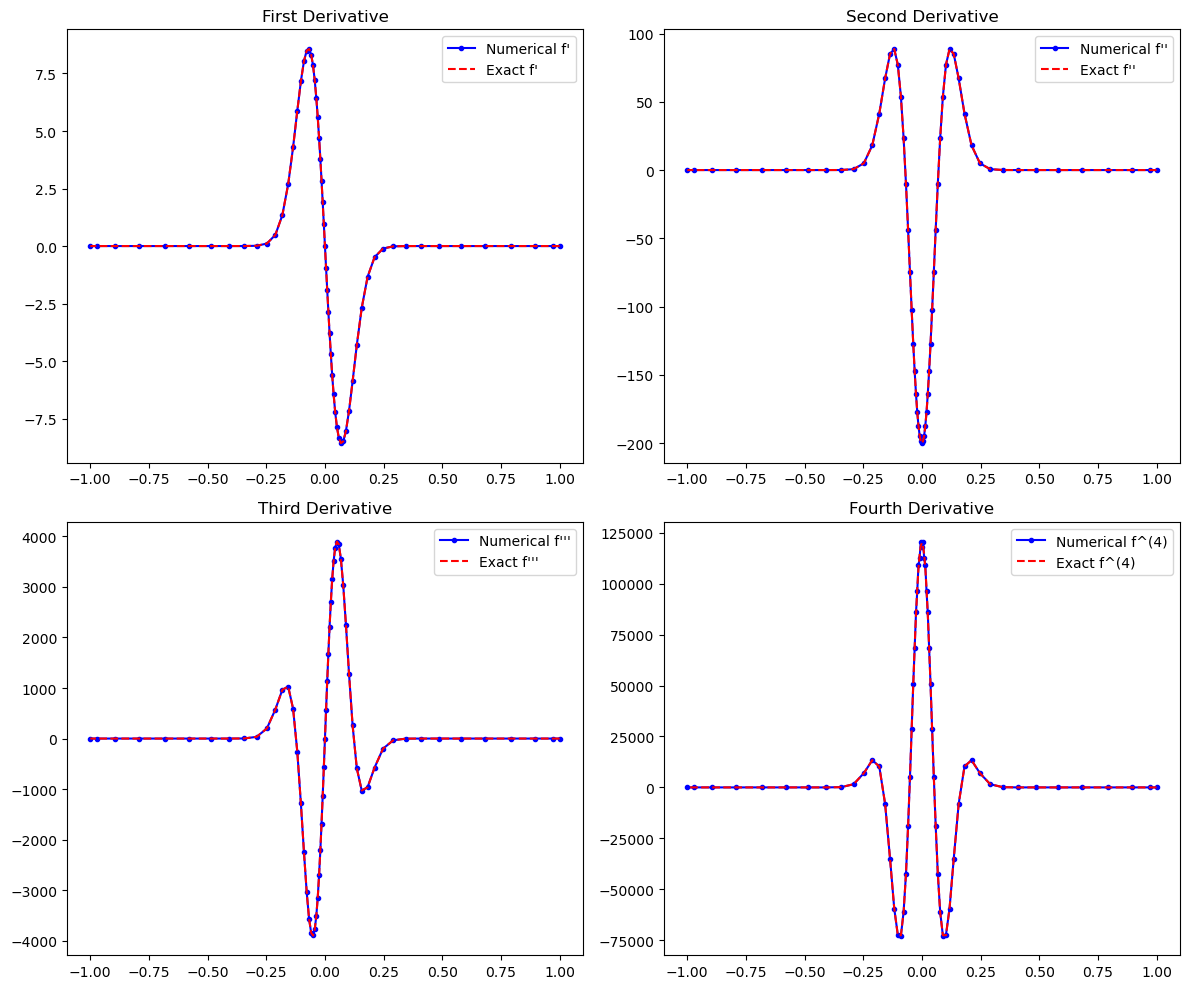

In [23]:
# Set the number of Chebyshev nodes
N = 60
D, x = cheb_mod(N,alpha = 10.0)

# Define the smooth Gaussian pulse
f = np.exp(-100 * x**2)

# Compute the differentiation matrices for higher derivatives
D1 = D
D2 = np.linalg.matrix_power(D, 2)
D3 = np.linalg.matrix_power(D, 3)
D4 = np.linalg.matrix_power(D, 4)

# Compute the numerical derivatives
f1_num = D1 @ f
f2_num = D2 @ f
f3_num = D3 @ f
f4_num = D4 @ f

# Analytical derivatives of f(x) = exp(-100*x^2)
f1_exact = -200 * x * np.exp(-100*x**2)
f2_exact = (40000*x**2 - 200) * np.exp(-100*x**2)
f3_exact = -200 * x * (40000*x**2 - 600) * np.exp(-100*x**2)
f4_exact = (1.6e9*x**4 - 48000000*x**2 + 120000) * np.exp(-100*x**2)

# Plotting the results
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(x, f1_num, 'b.-', label='Numerical f\'')
plt.plot(x, f1_exact, 'r--', label='Exact f\'')
plt.title('First Derivative')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x, f2_num, 'b.-', label='Numerical f\'\'')
plt.plot(x, f2_exact, 'r--', label='Exact f\'\'')
plt.title('Second Derivative')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x, f3_num, 'b.-', label='Numerical f\'\'\'')
plt.plot(x, f3_exact, 'r--', label='Exact f\'\'\'')
plt.title('Third Derivative')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(x, f4_num, 'b.-', label='Numerical f^(4)')
plt.plot(x, f4_exact, 'r--', label='Exact f^(4)')
plt.title('Fourth Derivative')
plt.legend()

plt.tight_layout()
plt.show()
